In [1]:
%run 'Functions.ipynb'

In [2]:
def terms_by_day(terms, start='1900-01-01', end='2020-01-01'):
    all_terms = Search(index='hep-analysis')[0:0] \
        .filter('range', earliest_date={'gte': start, 'lte': end})
    all_terms.aggs.bucket(
        'group_by_date', 
        'date_histogram', 
        field='earliest_date', 
        interval='day',
        format='date_optional_time'
    )

    given_terms = all_terms.query('match_phrase', **{'abstracts.value': terms})
    x, y = unzip(given_terms.execute().aggregations.group_by_date.buckets)
 
    if not len(y):
        return [], []
    
    total_x, total_y = unzip(all_terms.execute().aggregations.group_by_date.buckets)
    
    start = np.where(total_x == min(x))[0][0]
    end = np.where(total_x == max(x))[0][0]
    total_y = total_y[start:end+1]
        
    with np.errstate(divide='ignore', invalid='ignore'):
        normed_y = np.divide(y, total_y)
        normed_y[~ np.isfinite(normed_y)] = 0
        return x, normed_y

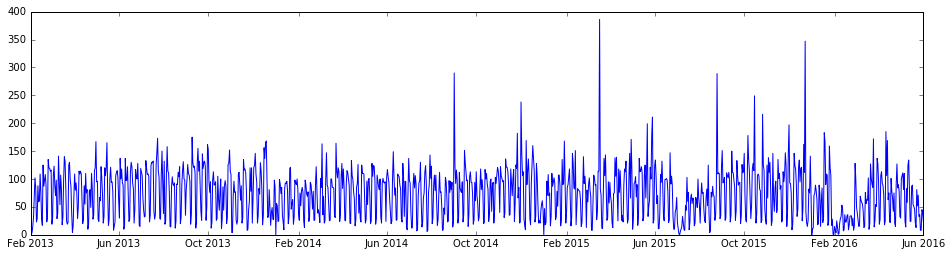

In [3]:
def all(start='1900-01-01', end='2020-01-01'):
    q = Search(index='hep-analysis')[0:0] \
    .filter('range', earliest_date={'gte': start, 'lt': end})
    q.aggs.bucket(
        'group_by_date', 
        'date_histogram', 
        field='earliest_date', 
        interval='day',
        format='date_optional_time'
    )
    return unzip(q.execute().aggregations.group_by_date.buckets)
x, y = all()
plt.plot(x, y)

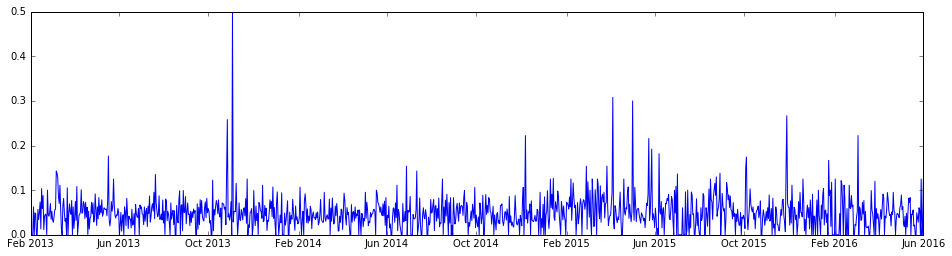

In [4]:
x, y = terms_by_day('gamma gamma')
plt.plot(x, y)

In [5]:
def repeat_sides(num, arr):
    arr = np.array(arr)
    left = np.ones(num) * arr[0]
    right = np.ones(num) * arr[-1]
    return np.append(left, np.append(arr, right))

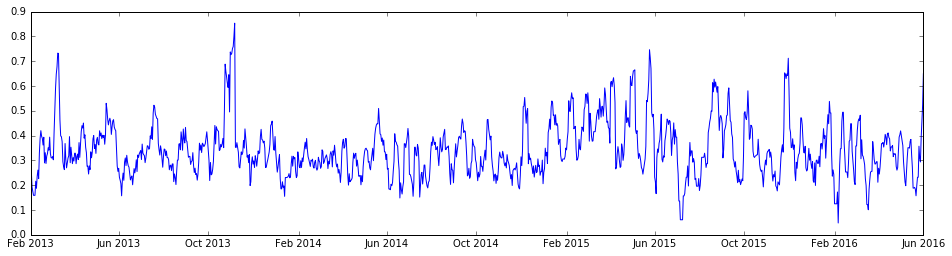

In [6]:
ay = sp.signal.convolve(repeat_sides(3, y), [1, 1, 1, 1, 1, 1, 1], mode='valid')
plt.plot(x, ay)

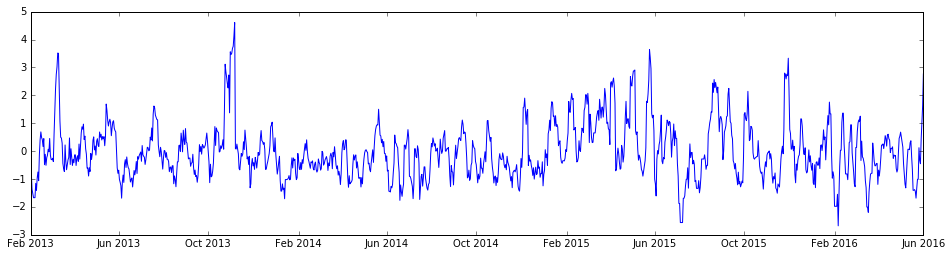

In [7]:
sy = sp.stats.zscore(ay)
plt.plot(x, sy)

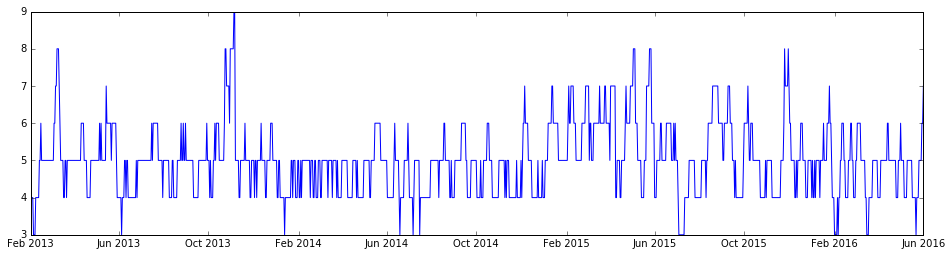

In [8]:
dy = np.digitize(sy, np.linspace(-5, 5, 10))
plt.plot(x, dy)

In [9]:
raw = fold_vectors(term_vectors(interval_ids('2015-01-01', days=20), 'abstracts.value'))

In [98]:
selected = {}
for k, v in sorted(raw.items()):
    if v['doc_freq'] >= 10:
        selected[k] = v

In [99]:
terms = sorted(selected.items(), key=lambda x: x[1]['doc_freq'])[:100]

In [103]:
len(raw)

102892

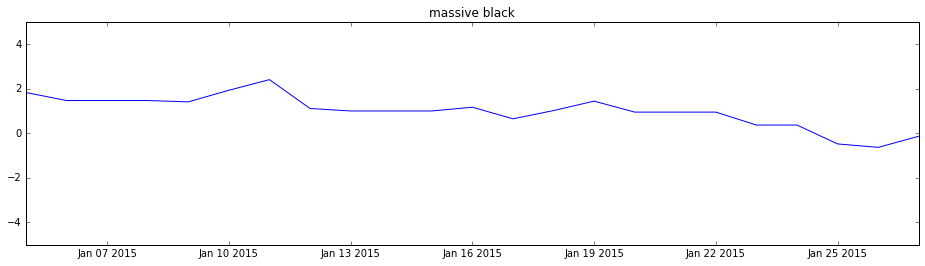

In [100]:
marked = []
unmarked = []

for term, _ in terms:

    x, y = terms_by_day(term, start='2015-01-01', end='2015-01-31')
    tx, ty = terms_by_day(term)
    
    if not len(y):
        continue
    
    ay = sp.signal.convolve(y, [1, 1, 1, 1, 1, 1, 1], mode='valid')
    aty = sp.signal.convolve(ty, [1, 1, 1, 1, 1, 1, 1], mode='valid')

    x = x[3:-3]
    tx = tx[3:-3]

    sy = (ay - np.mean(aty)) / np.std(aty)
    sty = (aty - np.mean(aty)) / np.std(aty)

    plt.gca().cla()

    plt.title(term)
    plt.ylim(-5, 5)
    plt.plot(x, sy)
    #plt.plot(tx, sty)
    
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf()) 
    
    command = input()
    if command == 'q':
        break
    elif command == 'a': # add mark
        marked.append(term)
    elif command == 'd': # delete mark
        unmarked.append(term)
        
IPython.display.clear_output()

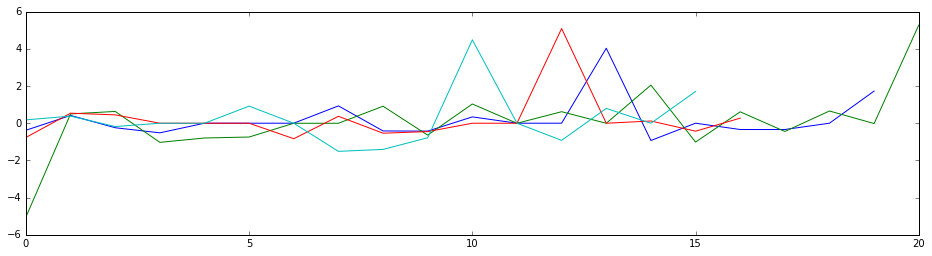

In [102]:
higher = []
lower = []

for term, _ in terms:

    x, y = terms_by_day(term, start='2015-01-01', end='2015-01-31')
    tx, ty = terms_by_day(term)
    
    if not len(y):
        continue
    
    ay = y
    aty = ty
    ay = sp.signal.convolve(ay, [1, -1], mode='valid')
    ay = sp.signal.convolve(ay, [1, 1, 1, 1, 1, 1, 1], mode='valid')
    aty = sp.signal.convolve(aty, [1, -1], mode='valid')
    aty = sp.signal.convolve(aty, [1, 1, 1, 1, 1, 1, 1], mode='valid')

    x = x[4:-4]
    tx = tx[4:-4]
    
    sy = (ay - np.mean(aty)) / np.std(aty)
    sty = (aty - np.mean(aty)) / np.std(aty)
    
    if sy[np.argmax(sy)] >= 4:
        plt.plot(sy)
        higher.append(term)
    else:
        lower.append(term)

In [ ]:
for term, _ in terms:

    x, y = terms_by_day(term, start='2015-01-01', end='2015-01-31')
    tx, ty = terms_by_day(term)
    
    if not len(y):
        continue

In [97]:
higher

['ska']